In [1]:
from __future__ import print_function
%matplotlib inline

from sklearn import cluster
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import cv2
import numpy as np
import math

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

In [2]:
def circle_fit(x_coords,y_coords,pixel_len):
    # Pre-processing for Circle Fitting Algorithm for Histological objects
    x1 = np.array(x_coords) # Array of x-coordinates 
    y1 = np.array(y_coords) # Array of y-coordinates

    # Apply transformation on x,y co-ordinates
    x2 = x1.reshape(1, pixel_len)
    y2 = y1.reshape(1, pixel_len)

    # Mean value of x co-ordinates
    sum_x=0
    for i in range(pixel_len):
        sum_x=sum_x+x2[0,i]
    x_mean=sum_x/(pixel_len -1)

    # Mean value of y co-ordinates
    sum_y=0
    for i in range(pixel_len):
        sum_y=sum_y+y2[0,i]
    y_mean=sum_y/(pixel_len - 1)
    
    # Circle Fitting Algorithm using linear algebra    
    u=[]
    v=[]
    Suv  = 0
    Suu  = 0
    Svv  = 0
    Suuv = 0
    Suvv = 0
    Suuu = 0
    Svvv = 0

    # calculation of the reduced coordinates
    for i in range(pixel_len):
            u.append((x2[0,i] - x_mean))
            v.append((y2[0,i] - y_mean))

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    for i in range(pixel_len):
        Suv  = Suv + (u[i]*v[i])
        Suu  = Suu+(u[i]*u[i])
        Svv  = Svv+(v[i]*v[i])
        Suuv = Suuv+(u[i]*u[i]*v[i])
        Suvv = Suvv+(u[i]* v[i]**2)
        Suuu = Suuu+(u[i]**3)
        Svvv = Svvv+(v[i]**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)

    xc_1 = x_mean + uc
    yc_1 = y_mean + vc

    # Calcuating Radius
    alpha = uc**2 + vc**2 +((Suu+Svv)/(pixel_len - 1))
    radius=math.sqrt(alpha)
    
    return xc_1, yc_1,radius 

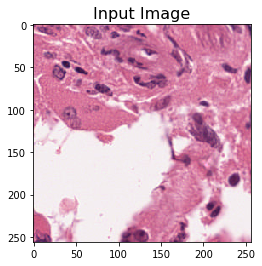

In [3]:
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

In [4]:
# Converting 3D image data into 2D data for k-means clustering
x, y, z = imInput.shape
image_2d = imInput.reshape(x*y, z)
image_2d.shape

(65536, 3)

In [5]:
# Applying K-means clusters on the given image
# As the input is image object, the clusters are color intensity
# Based on pixel (colored) distances from the respective cluster_centers
kmeans_cluster_00 = cluster.KMeans(n_clusters=3)
kmeans_cluster_00.fit(image_2d)
cluster_centers_00 = kmeans_cluster_00.cluster_centers_
cluster_labels_00 = kmeans_cluster_00.labels_

In [106]:
cluster_points =kmeans_cluster_00.predict(image_2d)

In [112]:
np.where(cluster_points == 2)

(array([    2,     3,     4, ..., 65533, 65534, 65535]),)

In [140]:
image_2d[0,:],image_2d[1,:], image_2d[10,:], image_2d[65535,:]

(Array([177,  90, 145], dtype=uint8),
 Array([187,  89, 138], dtype=uint8),
 Array([183,  96, 151], dtype=uint8),
 Array([213, 153, 187], dtype=uint8))

In [141]:
image_2d[37,:],image_2d[38,:], image_2d[0,:], image_2d[1,:], image_2d[2,:], image_2d[3,:]

(Array([229, 177, 200], dtype=uint8),
 Array([245, 202, 211], dtype=uint8),
 Array([177,  90, 145], dtype=uint8),
 Array([187,  89, 138], dtype=uint8),
 Array([199,  99, 137], dtype=uint8),
 Array([208, 113, 147], dtype=uint8))

In [144]:
cluster_labels_00

/home/raj/anaconda2/envs/py3opencv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


TypeError: object of type 'bool' has no len()

In [221]:
cluster_labels_00

array([1, 1, 2, ..., 2, 2, 2], dtype=int32)

In [7]:
# Each row represents respective cluster# 
# Each column in each row represents color intensity (RGB)
# For Eg, in this case, 3 clusters with their RGB values
# Cluster#0 is clustered with (243.01990705, 229.31279562, 233.74852959)
cluster_centers_00

array([[243.01990705, 229.31279562, 233.74852959],
       [142.47274174,  71.00358138, 121.60684441],
       [211.21876855, 127.25825318, 163.44356371]])

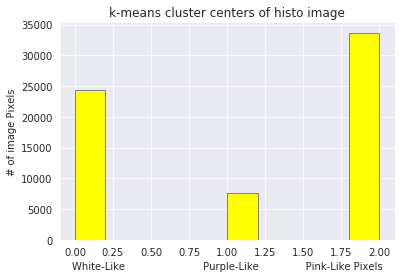

In [105]:
from matplotlib.ticker import FormatStrFormatter

data = cluster_labels_00
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(data, facecolor='yellow', edgecolor='gray')
ax.set_title('k-means cluster centers of histo image')
ax.set_ylabel('# of image Pixels')
ax.set_xlabel('White-Like                         Purple-Like               Pink-Like Pixels')

plt.show()

In [152]:
white = 0
purple = 0
pink = 0
for i in range (0,65535):
    if (cluster_labels_00[i] == 0): white=white+1
    if (cluster_labels_00[i] == 1): purple=purple+1
    if (cluster_labels_00[i] == 2): pink=pink+1

print (white, purple, pink)

24312 7543 33680


In [297]:
cluster_labels_00[37]

0

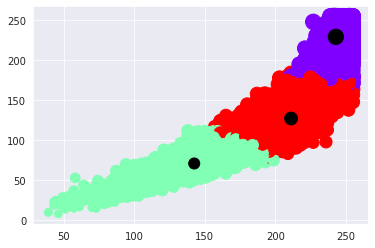

In [135]:
plt.scatter(image_2d[:,0],image_2d[:,1],image_2d[:,2], c=kmeans_cluster_00.labels_, cmap='rainbow') 
plt.scatter(kmeans_cluster_00.cluster_centers_[:,0],kmeans_cluster_00.cluster_centers_[:,1],kmeans_cluster_00.cluster_centers_[:,2], color='black')  

In [136]:
# To get the IDs of the points/samples that are inside each cluster
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

In [138]:
ClusterIndicesNumpy(0, cluster_labels_00), ClusterIndicesNumpy(1, cluster_labels_00), ClusterIndicesNumpy(2, cluster_labels_00)

(array([   37,    38,    39, ..., 65520, 65521, 65522]),
 array([    0,     1,    11, ..., 65498, 65499, 65500]),
 array([    2,     3,     4, ..., 65533, 65534, 65535]))

# PCA to get the circular objects

In [237]:
from sklearn.decomposition import PCA
import pandas as pd

In [238]:
# To save the image data into csv file to do PCA
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_00))
np.savetxt('/home/raj/Downloads/kmeans_data.csv', cluster_labels4d, delimiter=',')
np.savetxt('/home/raj/Downloads/df1.csv', image_2d, delimiter=',')
np.savetxt('/home/raj/Downloads/df1_cluster_labels.csv', cluster_labels_00, delimiter=',')

In [239]:
df = pd.read_csv('/home/raj/Downloads/kmeans_data.csv',names=['Red','Green','Blue','Cluster_No'])

In [240]:
from sklearn.preprocessing import StandardScaler
features = ['Red','Green','Blue']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['Cluster_No']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [241]:
x

array([[-1.14804115, -1.14199568, -0.93752544],
       [-0.8467837 , -1.15863125, -1.10277784],
       [-0.48527475, -0.99227559, -1.12638532],
       ...,
       [-0.03338857, -0.27694627, -0.13487094],
       [-0.06351432, -0.19376845, -0.040441  ],
       [-0.06351432, -0.09395505,  0.05398894]])

In [242]:
y

array([[1.],
       [1.],
       [2.],
       ...,
       [2.],
       [2.],
       [2.]])

In [243]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [244]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [245]:
finalDf = pd.concat([principalDf, df[['Cluster_No']]], axis = 1)

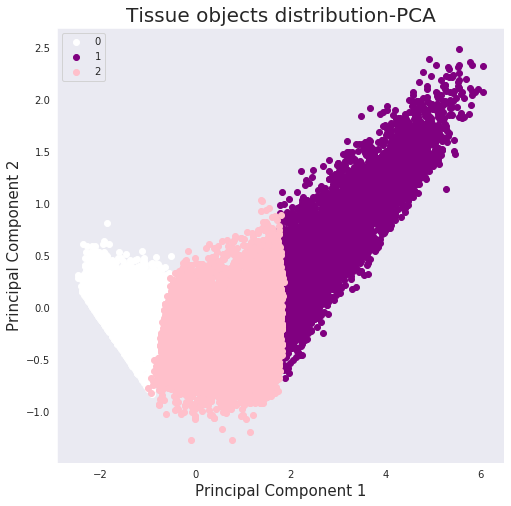

In [249]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Tissue objects distribution-PCA', fontsize = 20)
targets = [0,1,2]
colors = ['w', 'purple', 'pink']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Cluster_No'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PCA1']
               , finalDf.loc[indicesToKeep, 'PCA2']
               , c = color)    
ax.legend(targets)
ax.grid()

# PCA for individual tissue components 

In [223]:
cluster_labels_white = []
cluster_labels_purple = []
cluster_labels_pink = []

for i in range (0,65535):
    if (cluster_labels_00[i] == 0): cluster_labels_white.append(cluster_labels_00[i])
    if (cluster_labels_00[i] == 1): cluster_labels_purple.append(cluster_labels_00[i]) 
    if (cluster_labels_00[i] == 2): cluster_labels_pink.append(cluster_labels_00[i]) 

print (len(cluster_labels_white), len(cluster_labels_purple), len(cluster_labels_pink))

24312 7543 33680


In [226]:
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_purple))
np.savetxt('/home/raj/Downloads/purple_data.csv', cluster_labels4d, delimiter=',')

In [225]:
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_white))
np.savetxt('/home/raj/Downloads/white_data.csv', cluster_labels4d, delimiter=',')

In [227]:
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_labels_pink))
np.savetxt('/home/raj/Downloads/pink_data.csv', cluster_labels4d, delimiter=',')

# PCA on Cluster0 (White objects cluster)

In [229]:
whitedf = pd.read_csv('/home/raj/Downloads/white_data.csv',names=['Red','Green','Blue','Cluster_No'])

In [230]:
from sklearn.preprocessing import StandardScaler
features = ['Red','Green','Blue']
# Separating out the features
x = whitedf.loc[:, features].values
# Separating out the target
y = whitedf.loc[:,['Cluster_No']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [231]:
x, y

(array([[-0.73623719, -0.89381698, -0.55831668],
        [-0.43138652, -0.92244463, -0.8460216 ],
        [-0.06556572, -0.6361681 , -0.8871223 ],
        ...,
        [ 1.36723243,  2.57012902,  2.40093398],
        [ 1.42820257,  2.99954382,  2.31873257],
        [ 1.27577723,  2.7705226 ,  2.23653116]]), array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]))

In [232]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [233]:
finalDf = pd.concat([principalDf, df[['Cluster_No']]], axis = 1)

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Colored Tissue objects distribution-PCA', fontsize = 20)
targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Cluster_No'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PCA1']
               , finalDf.loc[indicesToKeep, 'PCA2']
               , c = color)
ax.legend(targets)
ax.grid()

In [235]:
imInput.shape, image_2d.shape

((256, 256, 3), (65536, 3))

# PCA Analysis followed by K-means

In [250]:
img_x = StandardScaler().fit_transform(image_2d)

In [252]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(img_x)
img_principalDf = pd.DataFrame(data = principalComponents, columns = ['PCA1'])

In [295]:
principalComponents[37]

array([-0.62437003])

# To do - 07/12/19
# Create an array[cluster_img_white, principal 
# components[cluster_img_white]]
# Find mean of principal components[cluster_img_white], low, high values
# Draw circles iteratively using circle_fit

In [255]:
kmeans_cluster_img = cluster.KMeans(n_clusters=3)
kmeans_cluster_img.fit(principalComponents)
cluster_centers_img = kmeans_cluster_img.cluster_centers_
cluster_labels_img = kmeans_cluster_img.labels_

In [257]:
cluster_labels4d=tuple(zip(*zip(*principalComponents),cluster_labels_img))
np.savetxt('/home/raj/Downloads/kmeans_img.csv', cluster_labels4d, delimiter=',')

# Splitting up Tissue objects

In [279]:
cluster_img_white = []
cluster_img_purple = []
cluster_img_pink = []

for i in range (0,65535):
    if (cluster_labels_img[i] == 0): cluster_img_white.append(i)
    if (cluster_labels_img[i] == 1): cluster_img_purple.append(i) 
    if (cluster_labels_img[i] == 2): cluster_img_pink.append(i) 

print (len(cluster_img_white), len(cluster_img_purple), len(cluster_img_pink))

24945 7257 33333


In [262]:
cluster_labels4d=tuple(zip(*zip(*principalComponents),cluster_img_white))
np.savetxt('/home/raj/Downloads/white_img.csv', cluster_labels4d, delimiter=',')
cluster_labels4d=tuple(zip(*zip(*principalComponents),cluster_img_purple))
np.savetxt('/home/raj/Downloads/purple_img.csv', cluster_labels4d, delimiter=',')
cluster_labels4d=tuple(zip(*zip(*image_2d),cluster_img_pink))
np.savetxt('/home/raj/Downloads/pink_img.csv', cluster_labels4d, delimiter=',')

In [293]:
cluster_img_white

[37,
 38,
 39,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 227,
 228,
 245,
 294,
 295,
 296,
 308,
 309,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 484,
 485,
 501,
 502,
 551,
 552,
 563,
 564,
 565,
 646,
 647,
 648,
 649,
 650,
 651,
 652,
 653,
 654,
 655,
 656,
 741,
 742,
 757,
 758,
 759,
 808,
 809,
 819,
 820,
 821,
 902,
 903,
 904,
 905,
 906,
 907,
 908,
 909,
 910,
 911,
 912,
 913,
 997,
 998,
 999,
 1014,
 1015,
 1076,
 1077,
 1078,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 1170,
 1254,
 1255,
 1270,
 1271,
 1332,
 1333,
 1334,
 1335,
 1415,
 1416,
 1417,
 1418,
 1419,
 1420,
 1421,
 1422,
 1423,
 1424,
 1425,
 1426,
 1511,
 1512,
 1526,
 1527,
 1590,
 1591,
 1592,
 1672,
 1673,
 1674,
 1675,
 1676,
 1677,
 1678,
 1679,
 1680,
 1681,
 1721,
 1722,
 1723,
 1767,
 1768,
 1792,
 1793,
 1837,
 1838,
 1847,
 1848,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1977,
 1978,
 1979,
 19

In [285]:
white_reshaped[0]

array([37])

In [264]:
image_2d[1,:],image_2d[2,:]

(Array([187,  89, 138], dtype=uint8), Array([199,  99, 137], dtype=uint8))

In [266]:
image_2d.shape, imInput.shape

((65536, 3), (256, 256, 3))

In [267]:
img_reshaped = np.reshape(image_2d, (256,256,3))

In [273]:
import sklearn.datasets, sklearn.decomposition

mu = np.mean(img_x, axis=0)

pca = sklearn.decomposition.PCA()
pca.fit(img_x)

nComp = 1
Xhat = np.dot(pca.transform(img_x)[:,:nComp], pca.components_[:nComp,:])
Xhat += mu

print(Xhat[0,])

[-1.03733458 -1.09254356 -1.0921461 ]


In [274]:
Xhat.shape

(65536, 3)

In [9]:
cluster_labels1=np.zeros((256,256))

In [10]:
cluster_labels1= cluster_labels_00.reshape(256, 256)

In [11]:
cluster_labels1.shape

(256, 256)

In [12]:
imOutput=cluster_centers_00[cluster_labels_00].reshape(x, y, z)

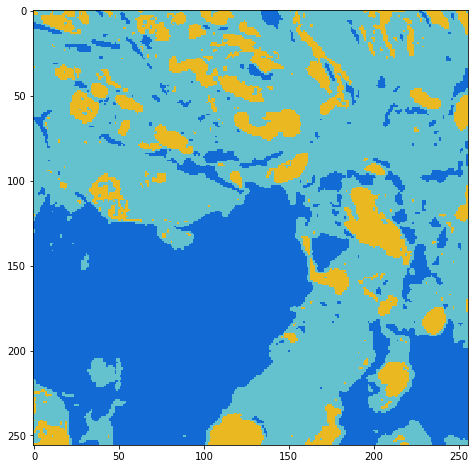

In [13]:
plt.figure(figsize = (15,8))
plt.imshow((imOutput * 255).astype(np.uint8))

In [14]:
imOutput.shape, imInput.shape

((256, 256, 3), (256, 256, 3))

In [15]:
imOutput.size

196608

In [16]:
cluster_labels_00

array([1, 1, 2, ..., 2, 2, 2], dtype=int32)

In [25]:
import circle_fit as cf

# Finding Largest Circle Object of Tissue component  (LOT)  - Procedure

# Finding LOT for first cluster (Cluster0 of 1st run of k-means)

In [17]:
# Adding up three cluster_positions with their x,y coordinates
cluster_00_x=[]
cluster_00_y=[]
cluster_01_x=[]
cluster_01_y=[]
cluster_02_x=[]
cluster_02_y=[]
for i in range(0,255):
       for j in range(0,255):
        if (cluster_labels1[i,j] == 0): cluster_00_x.append([i]),cluster_00_y.append([j])
        if (cluster_labels1[i,j] == 1): cluster_01_x.append([i]),cluster_01_y.append([j])
        if (cluster_labels1[i,j] == 2): cluster_02_x.append([i]),cluster_02_y.append([j])
z=len(cluster_00_x)+len(cluster_01_x)+len(cluster_02_x)
z

65025

In [18]:
# Identifying image positions/pixels matching nearest cluster0 intenstity values 
cluster_00_points = np.where(imInput ==(243, 229, 234)) #[243.01990705, 229.31279562, 233.74852959] Cluster#0 values

In [46]:
len(cluster_00_points)

3

In [49]:
cluster_00_points

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([136, 138, 141, ..., 187, 198, 236]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [21]:
# Splitting up image positios/pixels of cluster_00_points into another 3 clusters
# k-means clustering on points distance from cluster_center
# As the input is pixel co-ordinates, clusters are based pixel distance from cluster_center
cluster_00_0x=[]
cluster_00_1x=[]
cluster_00_2x=[]
cluster_00_0y=[]
cluster_00_1y=[]
cluster_00_2y=[]
for i in range(0,3509):
        if (cluster_00_points[2][i] == 0): cluster_00_0x.append(cluster_00_points[0][i]), cluster_00_0y.append(cluster_00_points[1][i])
        if (cluster_00_points[2][i] == 1): cluster_00_1x.append(cluster_00_points[0][i]), cluster_00_1y.append(cluster_00_points[1][i])
        if (cluster_00_points[2][i] == 2): cluster_00_2x.append(cluster_00_points[0][i]), cluster_00_2y.append(cluster_00_points[1][i])  

In [22]:
# Combining x,y coordinates for first cluster of cluster00
cluster_00_0_xy = np.vstack((cluster_00_0x, cluster_00_0y)).T 

In [23]:
np.shape(cluster_00_0_xy)

(3044, 2)

In [26]:
xc_00_0,yc_00_0,r_00_0,_ = cf.least_squares_circle((cluster_00_0_xy)) 

In [27]:
len(cluster_00_0_xy),len(cluster_00_1x), len(cluster_00_2x) 

(3044, 137, 328)

In [53]:
cluster_00_0_xy[:,0]

array([  0,   0,   0, ..., 255, 255, 255])

In [54]:
cluster_00_0_xy[:,1]

array([136, 138, 141, ...,  92,  99, 187])

In [28]:
kmeans_cluster_00_1 = cluster.KMeans(n_clusters=3)
kmeans_cluster_00_1.fit(cluster_00_0_xy)
cluster_00_1_centers= kmeans_cluster_00_1.cluster_centers_
cluster_00_1_labels= kmeans_cluster_00_1.labels_

In [30]:
cluster_00_1_centers

array([[185.4970684 ,  51.08338762],
       [149.98388626, 128.85308057],
       [218.61674009, 225.85022026]])

In [50]:
cluster_00_0_xy

array([[  0, 136],
       [  0, 138],
       [  0, 141],
       ...,
       [255,  92],
       [255,  99],
       [255, 187]])

In [51]:
# Identifying image positions/pixels matching nearest cluster0 intenstity values 
cluster_00_1_points = np.where(cluster_00_0_xy ==[185,51]) #[185.4970684, 51.08338762] Cluster#00 values

In [52]:
cluster_00_1_points

(array([ 676,  703,  814,  979, 1076, 1095, 1678, 1692, 1693, 1694, 1695,
        1696, 1697, 1698, 1699, 1700, 1700, 1701, 1702, 1703, 1704, 1705,
        1706, 1707, 1708, 1709, 1710, 1836, 1916, 1968, 2888, 2999, 3008]),
 array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]))

In [33]:
np.shape(cluster_00_1_points)

(2, 33)

In [35]:
# Splitting up cluster_00_0_points into another 3 clusters 
# First cluster from cluster0(Image)->cluster0(coordinates)
# k-means clustering on points distance from cluster_center
# As the input is pixel co-ordinates, clusters are based pixel distance from cluster_center
cluster_00_0_0x=[]
cluster_00_0_1x=[]
cluster_00_0_2x=[]
cluster_00_0_0y=[]
cluster_00_0_1y=[]
cluster_00_0_2y=[]Discovery and validation of a glioblastoma co-expressed gene module
for i in range(0,32):
        if (cluster_00_1_points[1][i] == 0): cluster_00_0_0x.append(cluster_00_1_points[0][i]), cluster_00_0_0y.append(255)
        if (cluster_00_1_points[1][i] == 1): cluster_00_0_1x.append(cluster_00_1_points[0][i]), cluster_00_0_1y.append(255)
        if (cluster_00_1_points[1][i] == 2): cluster_00_0_2x.append(cluster_00_1_points[0][i]), cluster_00_0_2y.append(255)

In [36]:
# Combining x,y coordinates for first cluster of cluster00
Discovery and validation of a glioblastoma co-expressed gene module = np.vstack((cluster_00_0_0x, cluster_00_0_0y)).T 

In [37]:
cluster_00_0_0xy

array([[1692,  255],
       [1693,  255],
       [1694,  255],
       [1695,  255],
       [1696,  255],
       [1697,  255],
       [1698,  255],
       [1699,  255],
       [1700,  255],
       [1701,  255],
       [1702,  255],
       [1703,  255],
       [1704,  255],
       [1705,  255],
       [1706,  255],
       [1707,  255],
       [1708,  255],
       [1709,  255],
       [1710,  255]])

In [38]:
xc_00_0_0,yc_00_0_0,r_00_0_0,_ = cf.least_squares_circle((cluster_00_0_0xy))  

In [ ]:
kmeans_cluster_00_0_1 = cluster.KMeans(n_clusters=3)
kmeans_cluster_00_0_1.fit(cluster_00_0_0_xy)
cluster_00_0_1_centers= kmeans_cluster_00_0_1.cluster_centers_
cluster_00_0_1_labels= kmeans_cluster_00_0_1.labels_

In [ ]:
cluster_00_0_1_centers

In [ ]:
# Identifying image positions/pixels matching nearest cluster00 intenstity values 
cluster_00_0_1_points = np.where(cluster_00_0_0_xy ==(1722,0)) #[1721.5,    0. ] Cluster#00_0_0 values#xc_00,yc_00,r_00,_ = cf.least_squares_circle((cluster_00_xy)) cluster_00_xy
xc_00_0,yc_00_0,r_00_0,_ = cf.least_squares_circle((cluster_00_0_xy)) 

In [ ]:
cluster_00_0_1_points

In [ ]:
cluster_00_0_1_point_0=[]
cluster_00_0_1_point_1=[]
cluster_00_0_1_point_2=[]
for i in range(0,22):
           if (cluster_00_0_1_point_0 == 0): cluster_00_0_1_point_0.append(combined0_0[i])
            if (cluster_00_0_1_point_1 == 1): cluster_00_0_1_point_1.append(combined0_0[i])
            if (cluster_00_0_1_point_2 == 2): cluster_00_0_1_point_2.append(combined0_0[i])

# Splitting up cluster_00_0_points into another 3 clusters 
# First cluster from cluster0(Image)->cluster0(coordinates)
# k-means clustering on points distance from cluster_center
# As the input is pixel co-ordinates, clusters are based pixel distance from cluster_center
cluster_00_0_1_0x=[]
cluster_00_0_1_1x=[]
cluster_00_0_1_2x=[]
cluster_00_0_1_0y=[]
cluster_00_0_1_1y=[]
cluster_00_0_1_2y=[]
for i in range(0,22):
        if (cluster_00_0_1_points[1][i] == 0): cluster_00_0_1_0x.append(cluster_00_1_points[0][i]), cluster_00_0_0y.append(cluster_00_1_points[1][i])
        if (cluster_00_0_1_points[1][i] == 1): cluster_00_0_1x.append(cluster_00_1_points[0][i]), cluster_00_0_1y.append(cluster_00_1_points[1][i])
        if (cluster_00_0_1_points[1][i] == 2): cluster_00_0_2x.append(cluster_00_1_points[0][i]), cluster_00_0_2y.append(cluster_00_1_points[1][i])  

In [ ]:
! pip install circle-fit
import circle_fit as cf

In [ ]:
# Applying Circle-fit algorithm on each cluster
#xc_00,yc_00,r_00,_ = cf.least_squares_circle((cluster_00_xy)) cluster_00_xy
xc_00_0,yc_00_0,r_00_0,_ = cf.least_squares_circle((cluster_00_0_xy)) 
#xc_00_0_0,yc_00_0_0,r_00_0_0,_ = cf.least_squares_circle((cluster_00_0_0_xy))  



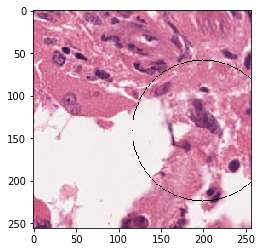

In [42]:
# Drawing Circles for each cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(xc_00_0),int(yc_00_0)),int(r_00_0),3)
#cv2.circle(imInput,(int(xc_00_0_0),int(yc_00_0_0)),int(r_00_0_0),3)

cv2.imwrite('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

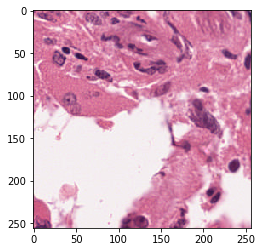

In [43]:
# Drawing Circles for each cluster
inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
#cv2.circle(imInput,(int(xc_00_0),int(yc_00_0)),int(r_00_0),3)
cv2.circle(imInput,(int(xc_00_0_0),int(yc_00_0_0)),int(r_00_0_0),3)

cv2.imwrite('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/clustered_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
np.shape(cluster_0_points)r

In [ ]:
# First Row represents, x-coordinates of position, Second row represents y-coordinates
# Third row represents respective cluster Number
# For Eg, the first columun value (0,136,0) represents, (0,136) position in the image with cluster#0
cluster_0_points

In [ ]:
# Cluster#0 intensity values [243.01990705, 229.31279562, 233.74852959]
# cluster_0, cluster_0, cluster_1, cluster_0
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,136], imInput[0,138], imInput[255,198], imInput[255,236] 

In [ ]:
# Identifying image positions/pixels matching nearest cluster1 intenstity values 
cluster_1_points = np.where(imInput ==(211, 127, 163)) #[211.21876855, 127.25825318, 163.44356371] Cluster#1 values

In [ ]:
cluster_1_points

In [ ]:
# Cluster#1 intensity values [211.21876855, 127.25825318, 163.44356371]
# cluster_0, cluster_1, cluster_2
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,33], imInput[0,56], imInput[255,226] 

In [ ]:
# Identifying image positions/pixels matching nearest cluster2 intenstity values 
cluster_2_points = np.where(imInput ==(142, 71, 121)) #[142.47274174,  71.00358138, 121.60684441] Cluster#2 values

In [ ]:
cluster_2_points

In [ ]:
# Cluster#1 intensity values [142.47274174,  71.00358138, 121.60684441]
# cluster_0, , cluster_1, cluster_2
# Position's Intensity values closely matches with respective cluster's intensity values
imInput[0,19],imInput[1,0], imInput[0,204]

In [ ]:
print(np.shape(cluster_0_points))
print(np.shape(cluster_1_points))
print(np.shape(cluster_2_points))

In [ ]:
cluster_0_points[0].shape, cluster_1_points[0].shape, cluster_2_points[0].shape

In [ ]:
#Splitting up image positios/pixels of cluster_1_points into another 3 clusters based on clusteral values 
cluster_1_0x=[]
cluster_1_1x=[]
cluster_1_2x=[]
cluster_1_0y=[]
cluster_1_1y=[]
cluster_1_2y=[]
for i in range(0,2326):
        if (cluster_1_points[2][i] == 0): cluster_1_0x.append(cluster_1_points[0][i]), cluster_1_0y.append(cluster_1_points[1][i])
        if (cluster_1_points[2][i] == 1): cluster_1_1x.append(cluster_1_points[0][i]), cluster_1_1y.append(cluster_1_points[1][i])
        if (cluster_1_points[2][i] == 2): cluster_1_2x.append(cluster_1_points[0][i]), cluster_1_2y.append(cluster_1_points[1][i])  

In [ ]:
#Splitting up image positios/pixels of cluster_2_points into another 3 clusters based on clusteral values 
cluster_2_0x=[]
cluster_2_1x=[]
cluster_2_2x=[]
cluster_2_0y=[]
cluster_2_1y=[]
cluster_2_2y=[]
for i in range(0,377):
        if (cluster_2_points[2][i] == 0): cluster_2_0x.append(cluster_2_points[0][i]), cluster_2_0y.append(cluster_2_points[1][i])
        if (cluster_2_points[2][i] == 1): cluster_2_1x.append(cluster_2_points[0][i]), cluster_2_1y.append(cluster_2_points[1][i])
        if (cluster_2_points[2][i] == 2): cluster_2_2x.append(cluster_2_points[0][i]), cluster_2_2y.append(cluster_2_points[1][i])  

### start

In [ ]:
# Cluster_0_0 Circle (Largest Object Circle) generation
cluste_0_0_len=len(cluster_0_0x)
cluster_0_0_x, cluster_0_0_y, cluster_0_0_radius = circle_fit(cluster_0_0x, cluster_0_0y, cluste_0_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_0_x)),int(round(cluster_0_0_y))),int(round(cluster_0_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_0_1 Circle (Largest Object Circle) generation
cluste_0_1_len=len(cluster_0_1x)
cluster_0_1_x, cluster_0_1_y, cluster_0_1_radius = circle_fit(cluster_0_1x, cluster_0_1y, cluste_0_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_1_x)),int(round(cluster_0_1_y))),int(round(cluster_0_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))           

im = cv2.imread('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_0_2 Circle (Largest Object Circle) generation
cluste_0_2_len=len(cluster_0_2x)
cluster_0_2_x, cluster_0_2_y, cluster_0_2_radius = circle_fit(cluster_0_2x, cluster_0_2y, cluste_0_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_0_2_x)),int(round(cluster_0_2_y))),int(round(cluster_0_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))           

im = cv2.imread('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_1_0 Circle (Largest Object Circle) generation
cluste_1_0_len=len(cluster_1_0x)
cluster_1_0_x, cluster_1_0_y, cluster_1_0_radius = circle_fit(cluster_1_0x, cluster_1_0y, cluste_1_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_0_x)),int(round(cluster_1_0_y))),int(round(cluster_1_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_1_1 Circle (Largest Object Circle) generation
cluste_1_1_len=len(cluster_1_1x)
cluster_1_1_x, cluster_1_1_y, cluster_1_1_radius = circle_fit(cluster_1_1x, cluster_1_1y, cluste_1_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_1_x)),int(round(cluster_1_1_y))),int(round(cluster_1_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_1_2 Circle (Largest Object Circle) generation
cluste_1_2_len=len(cluster_1_2x)
cluster_1_2_x, cluster_1_2_y, cluster_1_2_radius = circle_fit(cluster_1_2x, cluster_1_2y, cluste_1_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_1_2_x)),int(round(cluster_1_2_y))),int(round(cluster_1_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_2_0 Circle (Largest Object Circle) generation
cluste_2_0_len=len(cluster_2_0x)
cluster_2_0_x, cluster_2_0_y, cluster_2_0_radius = circle_fit(cluster_2_0x, cluster_2_0y, cluste_2_0_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_2_0_x)),int(round(cluster_2_0_y))),int(round(cluster_2_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_2_1 Circle (Largest Object Circle) generation
cluste_2_1_len=len(cluster_2_1x)
cluster_2_1_x, cluster_2_1_y, cluster_2_1_radius = circle_fit(cluster_2_1x, cluster_2_1y, cluste_2_1_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_2_1_x)),int(round(cluster_2_1_y))),int(round(cluster_2_1_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Cluster_2_2 Circle (Largest Object Circle) generation
cluste_2_2_len=len(cluster_2_2x)
cluster_2_2_x, cluster_2_2_y, cluster_2_2_radius = circle_fit(cluster_2_2x, cluster_2_2y, cluste_2_2_len)

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(round(cluster_2_2_x)),int(round(cluster_2_2_y))),int(round(cluster_2_2_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
fig=plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax1.set_title("Cluster0")
im1 = cv2.imread('/home/raj/Downloads/cluster_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,2)
ax1.set_title("Cluster1")
im1 = cv2.imread('/home/raj/Downloads/cluster_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,3)
ax1.set_title("Cluster2")
im1 = cv2.imread('/home/raj/Downloads/cluster_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,4)
ax1.set_title("Cluster3")
im1 = cv2.imread('/home/raj/Downloads/cluster_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,5)
ax1.set_title("Cluster4")
im1 = cv2.imread('/home/raj/Downloads/cluster_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,6)
ax1.set_title("Cluster5")
im1 = cv2.imread('/home/raj/Downloads/cluster_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,7)
ax1.set_title("Cluster6")
im1 = cv2.imread('/home/raj/Downloads/cluster_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,8)
ax1.set_title("Cluster7")
im1 = cv2.imread('/home/raj/Downloads/cluster_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,9)
ax1.set_title("Cluster8")
im1 = cv2.imread('/home/raj/Downloads/cluster_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.show()

## Using python package circle-fit

In [ ]:
! pip install circle-fit

In [ ]:
import circle_fit as cf

In [ ]:
# Cluster_0_0 Circle (Largest Object Circle) generation
combined2_2 = np.vstack((cluster_2_2x, cluster_2_2y)).T
xc_22,yc_22,r_22,_ = cf.least_squares_circle((combined2_2))

inputImageFile = ('/media/raj/Raj1_5/10ktiles/train/gbm/TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')  # H&E.png
imOrig = skimage.io.imread(inputImageFile)[:, :, :3]

imInput = imOrig.copy()
cv2.circle(imInput,(int(xc_22),int(yc_22)),int(r_22),3)
#cv2.circle(imInput,(int(round(cluster_0_0_x)),int(round(cluster_0_0_y))),int(round(cluster_0_0_radius)), 3)           
cv2.imwrite('/home/raj/Downloads/cluster_cf_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png',
            cv2.cvtColor(imInput, cv2.COLOR_RGB2BGR))
           
im = cv2.imread('/home/raj/Downloads/cluster_cf_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
fig=plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax1.set_title("Cluster0")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_0_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,2)
ax1.set_title("Cluster1")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_0_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,3)
ax1.set_title("Cluster2")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_0_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,4)
ax1.set_title("Cluster3")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_1_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,5)
ax1.set_title("Cluster4")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_1_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,6)
ax1.set_title("Cluster5")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_1_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,7)
ax1.set_title("Cluster6")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_2_0_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,8)
ax1.set_title("Cluster7")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_2_1_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))

ax1 = fig.add_subplot(3,3,9)
ax1.set_title("Cluster8")
im1 = cv2.imread('/home/raj/Downloads/cluster_cf_2_2_TCGA-02-0001-01Z-00-DX2_20x_4768_25216_256x256.png')
ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
plt.show()